* date : hourly date + timestamp
* season : 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
* holiday : 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌날
* workingday : 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일
* weather : 1=맑음, 약간 구름 낀 흐림, 2=안개, 안개 + 흐림, 3=가벼운 눈, 가벼운 비 + 천둥, 4=심한 눈/비, 천둥/번개
* temp:온도(섭씨)
* atemp:체감온도(섭씨)
* humidity:상대습도
* windspeed:풍속
* casual:사전에 등록되지 않는 사용자가 대여한 횟수
* registered:사전에 등록된 사용자가 대여한 횟수
* count:대여 횟수

1. csv 파일 읽어오기
2. info, desc
3. datetime 필드 -> 년, 월, 일, 시간
4. casual, registered 제거
5. x의 피처별 count의 관계를 막대그래프로 시각화
6. 데이터 분리
7. 모델 설정 : LinearRegression()
8. 훈련, predict,
9. matric 보기(rmse, rmsle)
* 주요 infortance값 시각화(coef_)
-------------------------------------------------------------
10. feature들을 one-hot encoding
11. RandomForestRegressor, GradientBoostingRegressor
XGBRegressor,LGBMRegressor 알고리즘 적용

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('./train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [54]:
drop_columns=['datetime','casual','registered']
bike_df.drop(drop_columns, axis =1 , inplace=True)

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def rmsle(y, pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    mean_squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(mean_squared_error))
    return rmsle
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))
def evaluate_regr(y, pred):
    rmsle_val=rmsle(y, pred)
    rmse_val=rmse(y, pred)
    mse_val=mean_absolute_error(y, pred)
    print('RMSLE : {0:.3f}, RMSE: {1:.3f}, MSE: {2:.3f}'.format(rmsle_val,rmse_val,mse_val))

In [56]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE : 1.165, RMSE: 140.900, MSE: 105.924


      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<AxesSubplot:>

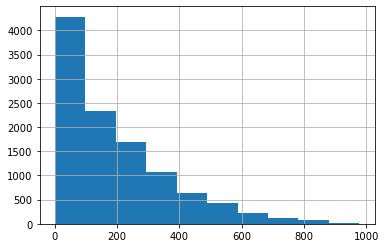

In [57]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)
y_target.hist()


<AxesSubplot:>

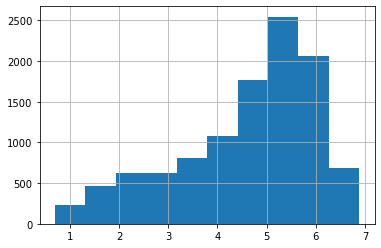

In [42]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [43]:
# 타겟 컬럼인 count 값을 log1p 로 Log 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE : 1.017, RMSE: 162.594, MSE: 109.286


<AxesSubplot:>

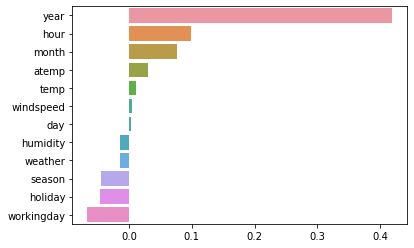

In [44]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

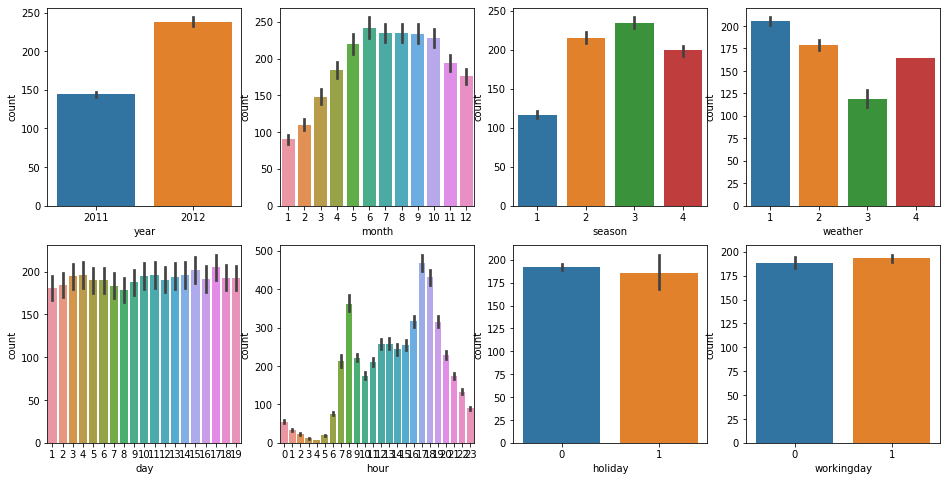

In [47]:
fig, axs= plt.subplots(figsize=(16,8),ncols=4,nrows=2)
cat_features=['year','month','season','weather','day','hour','holiday','workingday']
for i,feature in enumerate(cat_features):   
    row = int(i/4)
    col = i%4
    sns.barplot(x=feature, y='count',data=bike_df,ax=axs[row][col])

In [45]:
# 'year','month','hour','season','weather' feature들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','hour', 'holiday',
                                              'workingday','season','weather'])

In [32]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)


### LinearRegression ###
RMSLE : 0.589, RMSE: 97.484, MSE: 63.106
### Ridge ###
RMSLE : 0.589, RMSE: 98.407, MSE: 63.648
### Lasso ###
RMSLE : 0.634, RMSE: 113.031, MSE: 72.658


<AxesSubplot:>

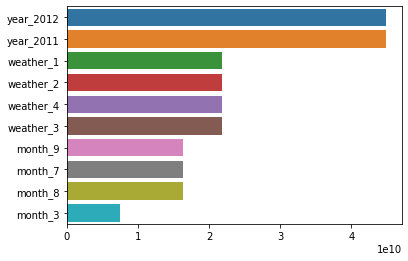

In [33]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

In [34]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### RandomForestRegressor ###
RMSLE : 0.353, RMSE: 50.789, MSE: 31.528
### GradientBoostingRegressor ###
RMSLE : 0.340, RMSE: 55.781, MSE: 34.343
### XGBRegressor ###
RMSLE : 0.339, RMSE: 50.950, MSE: 30.891
### LGBMRegressor ###
RMSLE : 0.316, RMSE: 46.473, MSE: 28.777


<function __main__.get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False)>